In [ ]:
#Kütüphaneler ve ayarlar
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

#Tekrarlanabilirlik için (Her seferinde aynı sonucu almak için)
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

#Cihaz seçimi (GPU varsa kullan)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

#HİPERPARAMETRELER
BATCH_SIZE = 32
EPOCHS = 20    #İstersen artırabilirsin
LR = 1e-4      #MobileNet için biraz daha düşük learning rate iyidir
PATIENCE = 5   #Erken durdurma sabrı

Kullanılan Cihaz: cpu


In [ ]:
#Dosya yollarını okuma
DATA_DIR = "dataset" 

if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Klasör bulunamadı: {DATA_DIR}")

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

print(f"Sınıflar: {class_names}")
# Çıktılar ['Cloudy', 'Rain', 'Shine', 'Sunrise'] 

image_paths = []
image_labels = []

for label_idx, class_name in enumerate(class_names):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                image_labels.append(label_idx)

print(f"Toplam resim sayısı: {len(image_paths)}")

Sınıflar: ['Cloudy', 'Rain', 'Shine', 'Sunrise']
Toplam resim sayısı: 1125


In [ ]:
#Veri bölme ve transformlar

#Veriyi Train (%70), Val (%15), Test (%15) olarak bölüyoruz
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, image_labels, test_size=0.3, stratify=image_labels, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

#MobileNetV2 için 224x224 boyutu idealdir
IMG_SIZE = 224 

#Eğitim için veri çoğaltma (Augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#Test ve Val için sadece boyutlandırma
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])#Dataset sınıfı ve dataLoader

class WeatherDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        
        #Resmi aç ve RGB'ye çevir
        image = Image.open(path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

#Dataset nesneleri
train_ds = WeatherDataset(X_train, y_train, transform=train_transforms)
val_ds = WeatherDataset(X_val, y_val, transform=test_transforms)
test_ds = WeatherDataset(X_test, y_test, transform=test_transforms)

#DataLoaderlar
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

Train: 787, Val: 169, Test: 169


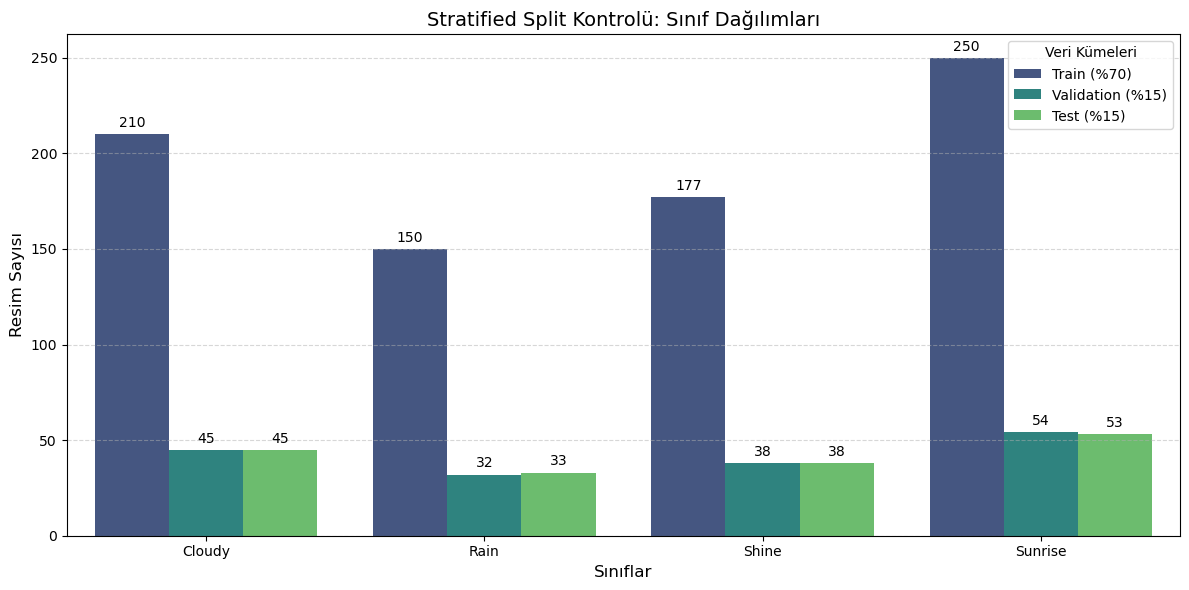

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

#Her kümedeki etiket sayılarını hesapla
# y_train, y_val, y_test listeleri zaten hafızada
train_counts = Counter(y_train)
val_counts = Counter(y_val)
test_counts = Counter(y_test)

#Veriyi tablo haline getir (DataFrame)
data = []
for i, class_name in enumerate(class_names):
    # Train bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Train (%70)', 'Adet': train_counts[i]})
    # Val bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Validation (%15)', 'Adet': val_counts[i]})
    # Test bilgisini ekle
    data.append({'Sınıf': class_name, 'Küme': 'Test (%15)', 'Adet': test_counts[i]})

df_dagilim = pd.DataFrame(data)

#Grafiği çiz
plt.figure(figsize=(12, 6))
sns.barplot(data=df_dagilim, x='Sınıf', y='Adet', hue='Küme', palette='viridis')

plt.title('Stratified Split Kontrolü: Sınıf Dağılımları', fontsize=14)
plt.xlabel('Sınıflar', fontsize=12)
plt.ylabel('Resim Sayısı', fontsize=12)
plt.legend(title='Veri Kümeleri')
plt.grid(axis='y', linestyle='--', alpha=0.5)

#Çubukların üzerine sayıları yaz
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

In [ ]:
#Model Tanımlama (MobileNetV2)

#Önceden eğitilmiş ağırlıkları yüklüyoruz
weights = models.MobileNet_V2_Weights.DEFAULT
model = models.mobilenet_v2(weights=weights)

#Modelin son katmanını (classifier) kendi sınıf sayımıza göre değiştiriyoruz
#MobileNetV2'de son katman: model.classifier[1]
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(class_names))

model = model.to(DEVICE)

#Optimizer ve Loss
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
#Eğitim ve değerlendirme fonksiyonları

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        #MobileNetV2 sadece tek çıktı verir
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), 100 * correct / total

In [ ]:
#Ana eğitim döngüsü

best_val_acc = 0.0
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("Eğitim Başlıyor...")

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    scheduler.step(val_acc)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    #En iyi modeli kaydet ve Early Stopping kontrolü
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_mobilenetv2.pth")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Erken durdurma (Early Stopping) tetiklendi!")
            break

print("Eğitim Tamamlandı.")

Eğitim Başlıyor...
Epoch 1/20 | Train Loss: 1.1642 Acc: 61.63% | Val Loss: 0.8828 Acc: 89.94%
Epoch 2/20 | Train Loss: 0.6503 Acc: 91.49% | Val Loss: 0.4126 Acc: 96.45%
Epoch 3/20 | Train Loss: 0.2648 Acc: 97.20% | Val Loss: 0.1915 Acc: 95.86%
Epoch 4/20 | Train Loss: 0.1595 Acc: 96.57% | Val Loss: 0.1294 Acc: 95.27%
Epoch 5/20 | Train Loss: 0.1003 Acc: 97.84% | Val Loss: 0.0969 Acc: 97.04%
Epoch 6/20 | Train Loss: 0.0640 Acc: 98.35% | Val Loss: 0.0815 Acc: 98.22%
Epoch 7/20 | Train Loss: 0.0717 Acc: 98.09% | Val Loss: 0.0654 Acc: 98.22%
Epoch 8/20 | Train Loss: 0.0481 Acc: 99.24% | Val Loss: 0.0579 Acc: 98.82%
Epoch 9/20 | Train Loss: 0.0445 Acc: 98.98% | Val Loss: 0.0574 Acc: 98.82%
Epoch 10/20 | Train Loss: 0.0296 Acc: 99.62% | Val Loss: 0.0492 Acc: 98.82%
Epoch 11/20 | Train Loss: 0.0256 Acc: 99.75% | Val Loss: 0.0439 Acc: 98.82%
Epoch 12/20 | Train Loss: 0.0232 Acc: 99.75% | Val Loss: 0.0438 Acc: 98.82%
Epoch 13/20 | Train Loss: 0.0220 Acc: 99.49% | Val Loss: 0.0463 Acc: 98.82%
Er

/var/folders/q_/sjb73cls7qg8129c74d5cb3m0000gn/T/ipykernel_9839/3893228470.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_mobilen

Test Accuracy: 0.9763313609467456

Sınıflandırma Raporu:
               precision    recall  f1-score   support

      Cloudy       0.94      1.00      0.97        45
        Rain       1.00      1.00      1.00        33
       Shine       0.97      0.92      0.95        38
     Sunrise       1.00      0.98      0.99        53

    accuracy                           0.98       169
   macro avg       0.98      0.98      0.98       169
weighted avg       0.98      0.98      0.98       169



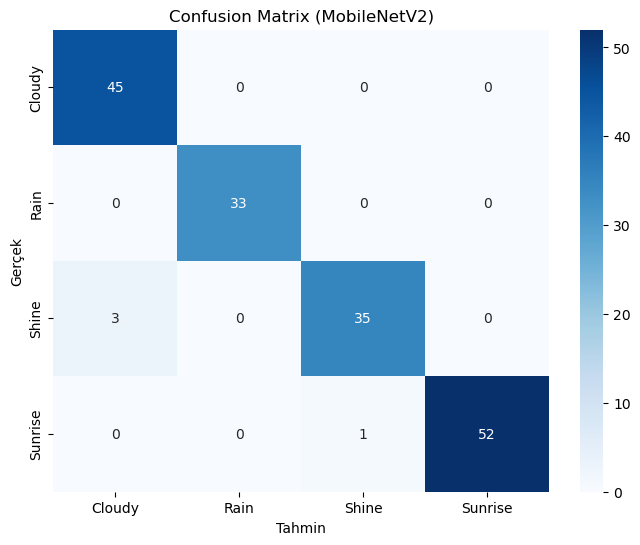

In [ ]:
#Test ve raporlama

#En iyi ağırlıkları yükle
model.load_state_dict(torch.load("best_mobilenetv2.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#Metrikler
print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("\nSınıflandırma Raporu:\n", classification_report(all_labels, all_preds, target_names=class_names))

#Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix (MobileNetV2)')
plt.show()

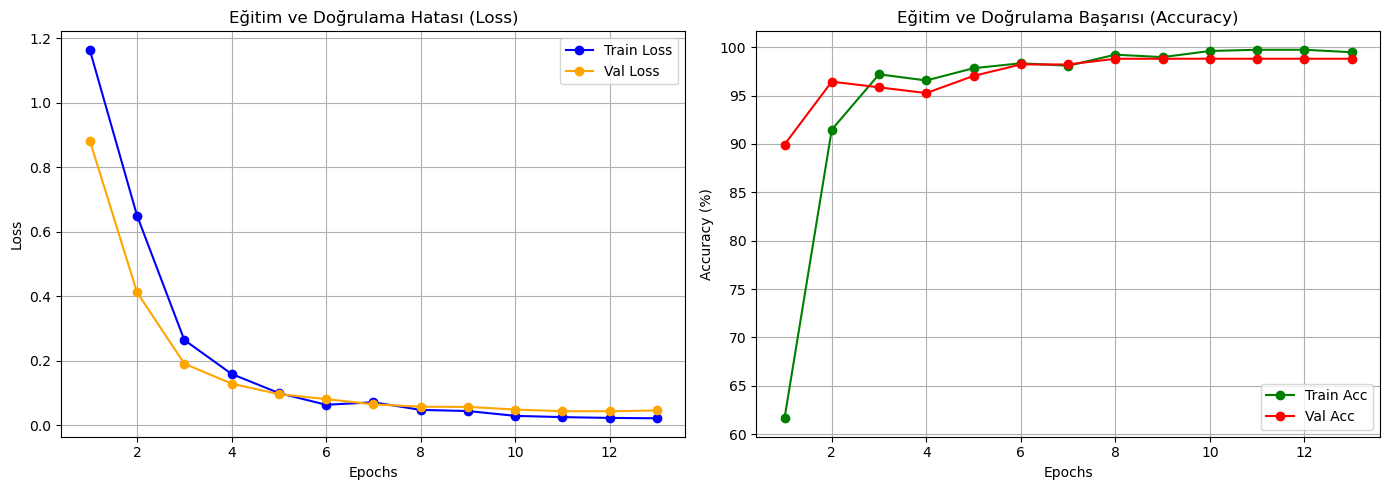

In [ ]:
#Grafik çizimi: Loss ve Accuracy Değişimleri

import matplotlib.pyplot as plt

#Eğitim kaç epoch sürdüyse ona göre x ekseni oluştur
epochs_ran = range(1, len(train_losses) + 1)

#Grafik: LOSS (Hata) Değişimi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_ran, train_losses, '-o', label='Train Loss', color='blue')
plt.plot(epochs_ran, val_losses, '-o', label='Val Loss', color='orange')
plt.title('Eğitim ve Doğrulama Hatası (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#Grafik: ACCURACY (Başarı) Değişimi
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, train_accs, '-o', label='Train Acc', color='green')
plt.plot(epochs_ran, val_accs, '-o', label='Val Acc', color='red')
plt.title('Eğitim ve Doğrulama Başarısı (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ROC Eğrisi için olasılıklar hesaplanıyor...


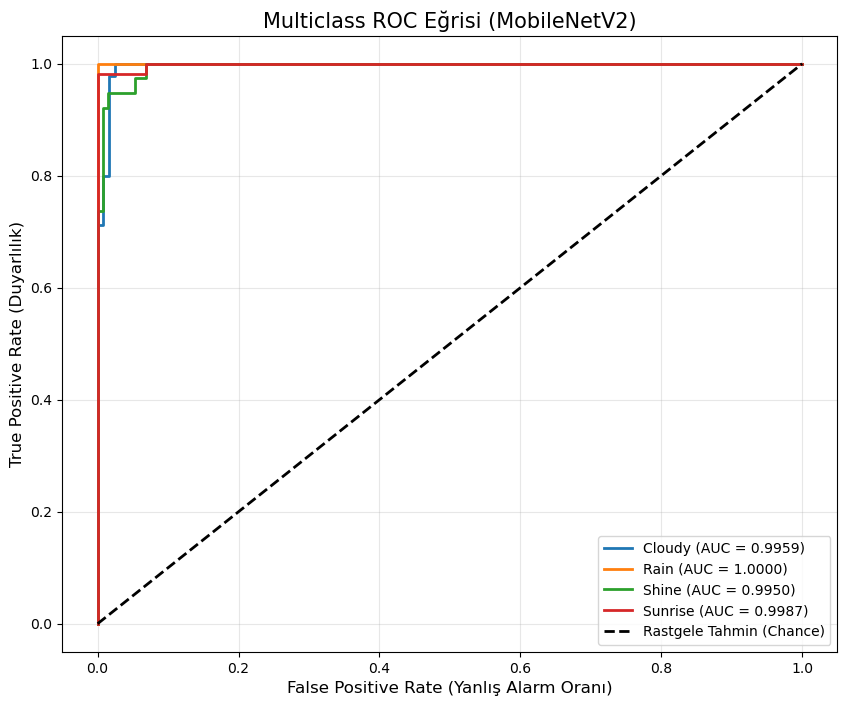

In [ ]:
#ROC Eğrisi ve AUC Hesaplama

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

#Önce test verisi üzerindeki OLASILIKLARI (Probabilities) al
model.eval()
y_test_true = []
y_test_probs = []

print("ROC Eğrisi için olasılıklar hesaplanıyor...")

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        
        #Çıktıları olasılığa çevir (Softmax)
        probs = torch.softmax(outputs, dim=1)
        
        y_test_probs.extend(probs.cpu().numpy())
        y_test_true.extend(labels.cpu().numpy())

y_test_true = np.array(y_test_true)
y_test_probs = np.array(y_test_probs)

#Etiketleri Binarize Et (Örn: 2 -> [0, 0, 1, 0] formatına çevir)
n_classes = len(class_names)
y_true_bin = label_binarize(y_test_true, classes=list(range(n_classes)))

#Grafiği Çiz
plt.figure(figsize=(10, 8))

#Her sınıf için ayrı ayrı eğri çiz
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_test_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{class_names[i]} (AUC = {roc_auc:.4f})')

#Referans çizgisi (Rastgele tahmin çizgisi)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Tahmin (Chance)')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate (Yanlış Alarm Oranı)', fontsize=12)
plt.ylabel('True Positive Rate (Duyarlılık)', fontsize=12)
plt.title('Multiclass ROC Eğrisi (MobileNetV2)', fontsize=15)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

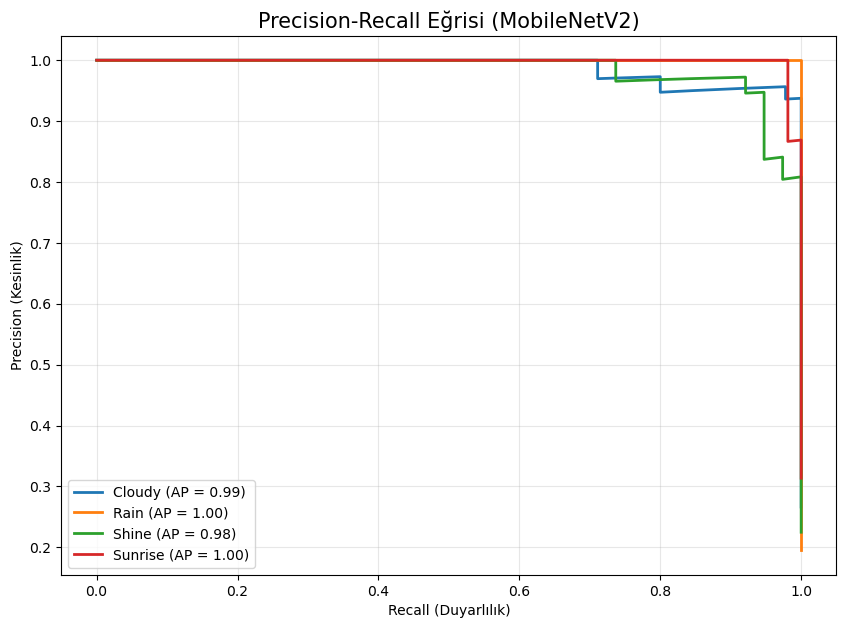

In [ ]:
#Precision-Recall Eğrileri

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 7))

#Her sınıf için eğri çiz
for i, cls in enumerate(class_names):
    #Bizim değişkenlerimiz: y_true_bin, y_test_probs
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_test_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_test_probs[:, i])
    
    plt.plot(recall, precision, lw=2, label=f"{cls} (AP = {ap:.2f})")

plt.title("Precision-Recall Eğrisi (MobileNetV2)", fontsize=15)
plt.xlabel("Recall (Duyarlılık)")
plt.ylabel("Precision (Kesinlik)")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

Model Tahmin Örnekleri:


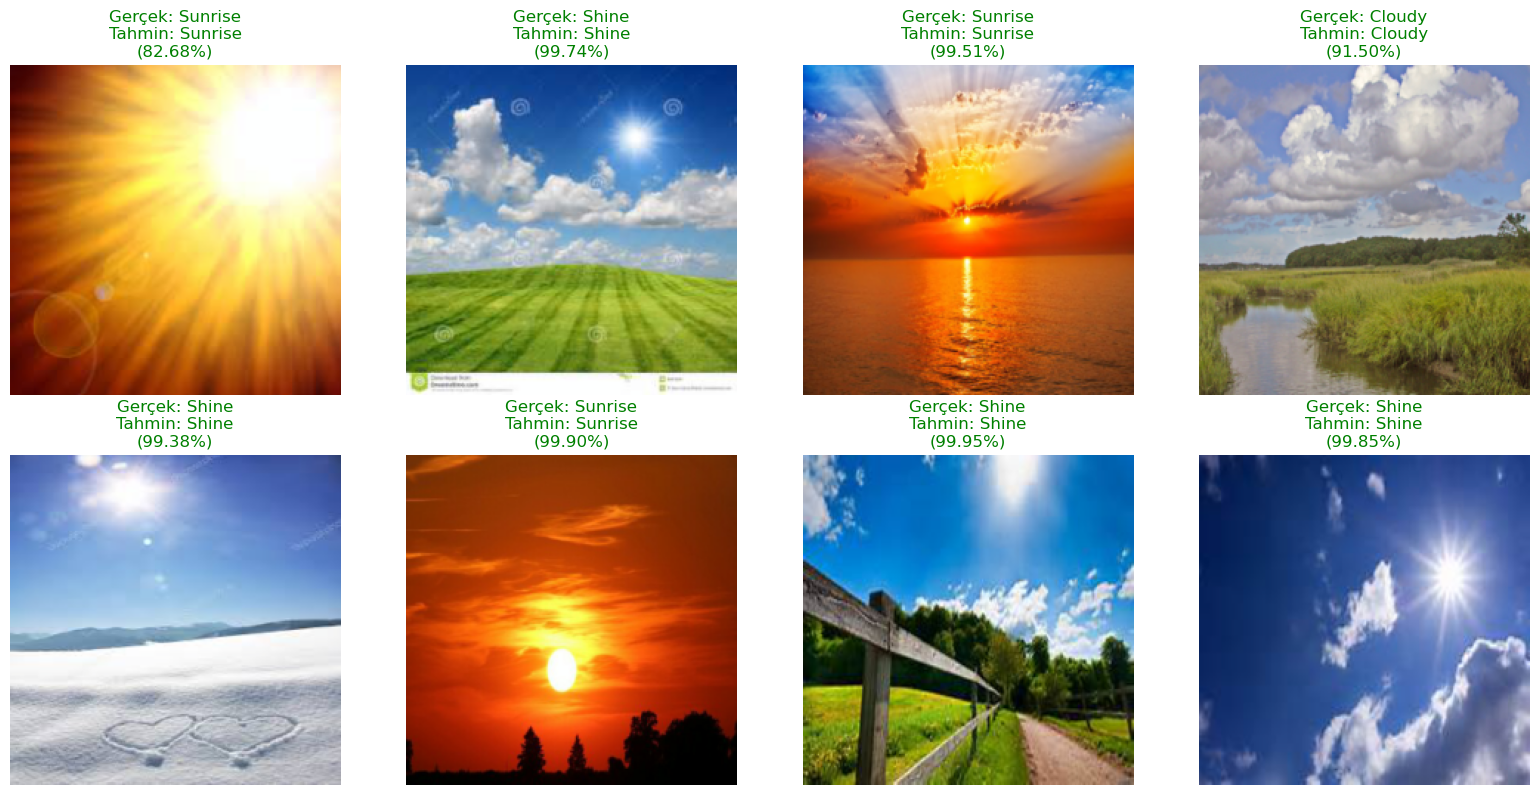

In [ ]:
#Tahminleri Görselleştirme (Show Samples)

def denormalize(tensor):
    """
    Model için normalize edilmiş (renkleri değiştirilmiş) resmi 
    tekrar insan gözünün göreceği orijinal renklere çevirir.
    """
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    #(Channel, Height, Width) -> (Height, Width, Channel)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    
    #Geri alma işlemi (Un-normalize)
    img = img * std + mean
    
    #Sayısal hataları önlemek için 0-1 arasına sabitleme
    img = np.clip(img, 0, 1)
    return img

def show_samples(model, loader, class_names, n=8):
    model.eval() # Modeli değerlendirme moduna al
    
    #Dataloader'dan bir paket (batch) veri al
    images, labels = next(iter(loader)) 
    
    #Sadece n tanesini seç
    images = images[:n]
    labels = labels[:n]
    
    images = images.to(DEVICE)
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1) #Olasılıkları hesapla
        preds = torch.argmax(probs, dim=1)    #En yüksek olasılıklı sınıfı seç
        
    plt.figure(figsize=(16, 8))
    for i in range(n):
        img = denormalize(images[i])
        true_label = class_names[labels[i].item()]
        pred_label = class_names[preds[i].item()]
        prob = probs[i][preds[i]].item()
        
        #Tahmin doğruysa başlık Yeşil, yanlışsa Kırmızı olsun
        color = 'green' if true_label == pred_label else 'red'
        
        plt.subplot(2, 4, i+1) #2 satır, 4 sütunlu ızgara
        plt.imshow(img)
        plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}\n({prob:.2%})", color=color, fontsize=12)
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

#Fonksiyonu Test seti üzerinde çalıştır
print("Model Tahmin Örnekleri:")
show_samples(model, test_loader, class_names, n=8)